**IMPORTING THE LIBRARIES**

In [1]:
import string
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print("TENSORFLOW_VERSION"+ tf.__version__)
print("TENSORFLOW DECISION FORESTS "+ tfdf.__version__)

TENSORFLOW_VERSION2.13.0
TENSORFLOW DECISION FORESTS 1.5.0


**LOADING THE DATASET**

In [3]:
df_train_prompt=pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv")
print("SHAPE OF FULL PROMPT DATASET is {}".format(df_train_prompt.shape))

SHAPE OF FULL PROMPT DATASET is (4, 4)


In [4]:
df_train_prompt.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [5]:
df_train_summ=pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv")
print("Shape of train summaries {}".format(df_train_summ.shape))

Shape of train summaries (7165, 5)


In [6]:
df_train_summ.head()


,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [7]:
df_train=df_train_summ.merge(df_train_prompt,on='prompt_id')
print("COMBINED TRAINING SET SHAPE {}". format(df_train.shape))

COMBINED TRAINING SET SHAPE (7165, 8)


In [8]:
df_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


In [9]:
#describe function gives count,mean,std,min,25%,75% and max of numerical entries
df_train.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   student_id       7165 non-null   object 
 1   prompt_id        7165 non-null   object 
 2   text             7165 non-null   object 
 3   content          7165 non-null   float64
 4   wording          7165 non-null   float64
 5   prompt_question  7165 non-null   object 
 6   prompt_title     7165 non-null   object 
 7   prompt_text      7165 non-null   object 
dtypes: float64(2), object(6)
memory usage: 447.9+ KB


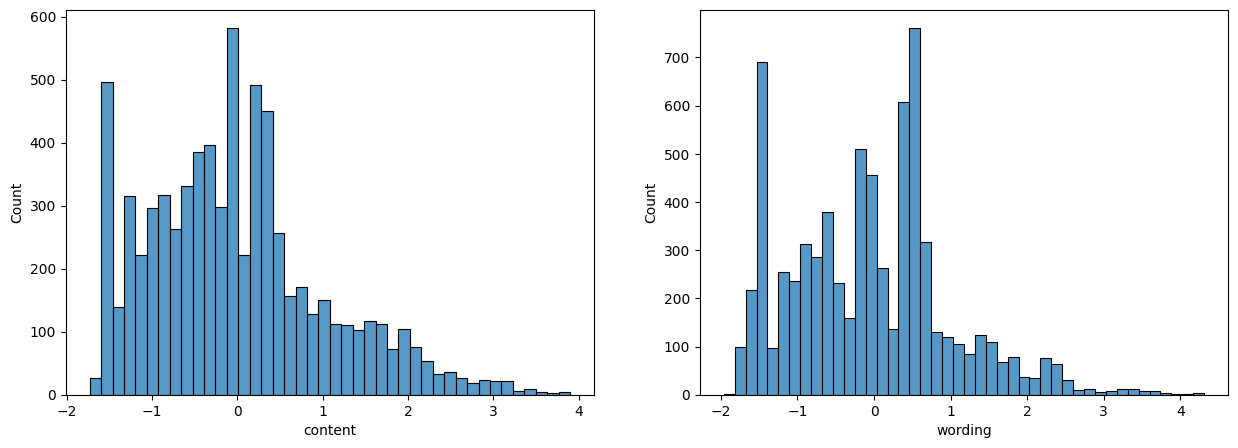

In [11]:
plt.figure(figsize=(15,5))
#plot with one row and 2 columns
plt.subplot(1,2,1)
sns.histplot(data=df_train,x='content')
plt.subplot(1,2,2)
sns.histplot(data=df_train,x='wording')
plt.show()

**PREPROCESSING THE DATA**

In [12]:
#function to count stopwords
def count_stopwords(text:str)->int:
    #nltk collects list of all stopwords
    stopword_list=set(stopwords.words('english'))
    #text is split using whitespaces
    words=text.split()
    #check if word is in list of stopwords: count++
    stopwords_count=sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

In [13]:
def count_punctuation(text:str)->int:
    punctuation_list=set(string.punctuation)
    punctuation_count=sum(1 for char in text if char in punctuation_list)
    return punctuation_count

In [14]:
def count_numbers(text:str)->int:
    numbers=re.findall(r'\d',text)
    numbers_count=len(numbers)
    return numbers_count

In [15]:
def feature_creation(dataframe:pd.DataFrame, feature:str='text')->pd.DataFrame:
    dataframe[f'{feature}_word_cnt']=dataframe[feature].apply(lambda x:len(x.split(' ')))
    dataframe[f'{feature}_char_len']=dataframe[feature].apply(lambda x:len(x))
    dataframe[f'{feature}_stopwords_cnt']=dataframe[feature].apply(lambda x:count_stopwords(x))
    dataframe[f'{feature}_punctuation_cnt']=dataframe[feature].apply(lambda x:count_punctuation(x))
    dataframe[f'{feature}_number_cnt']=dataframe[feature].apply(lambda x:count_numbers(x))
    return dataframe

In [16]:
preprocessed_df=feature_creation(df_train)
print('PREPROCESSED DATASET SHAPE {}'.format(preprocessed_df.shape))

PREPROCESSED DATASET SHAPE (7165, 13)


In [17]:
preprocessed_df.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_word_cnt,text_char_len,text_stopwords_cnt,text_punctuation_cnt,text_number_cnt
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,61,346,25,3,0
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,206,1225,92,30,8
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,60,345,27,9,0
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,76,451,35,10,0
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27,145,12,2,0


In [18]:
preprocessed_df.describe()

,content,wording,text_word_cnt,text_char_len,text_stopwords_cnt,text_punctuation_cnt,text_number_cnt
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,76.155618,418.776971,36.306769,9.355059,0.508304
std,1.043569,1.036048,54.538587,307.833685,25.813092,9.474397,1.351776
min,-1.729859,-1.962614,22.000000,114.000000,5.000000,0.000000,0.000000
25%,-0.799545,-0.872720,40.000000,216.000000,19.000000,4.000000,0.000000
50%,-0.093814,-0.081769,59.000000,320.000000,28.000000,6.000000,0.000000
75%,0.499660,0.503833,93.000000,513.000000,45.000000,12.000000,0.000000
max,3.900326,4.310693,651.000000,3940.000000,315.000000,162.000000,19.000000


**EXTRACT FEATURE COLUMNS**

In [19]:
feature_columns=preprocessed_df.drop(columns=['student_id','prompt_id','text','content','wording','prompt_question','prompt_title','prompt_text'],axis=1).columns.to_list()

In [20]:
feature_columns

['text_word_cnt',
 'text_char_len',
 'text_stopwords_cnt',
 'text_punctuation_cnt',
 'text_number_cnt']

**SPLITTING DATASET**

In [21]:
def split_dataset(dataset, ratio=.2):
    test_set=np.random.rand(len(dataset))<ratio
    return dataset[~test_set],dataset[test_set]

train_set,test_set=split_dataset(preprocessed_df)
train_set.shape,test_set.shape

((5771, 13), (1394, 13))

In [22]:
train_set.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_word_cnt,text_char_len,text_stopwords_cnt,text_punctuation_cnt,text_number_cnt
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,206,1225,92,30,8
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,60,345,27,9,0
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27,145,12,2,0
5,014e2395b3c4,814d6b,The Thrid Wave movement in the school has more...,1.376083,2.389443,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,126,734,67,7,0
6,01d303ea2f62,814d6b,The Third Wave developed and spead over such a...,0.735204,2.346576,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,133,767,68,16,0


In [23]:
test_set.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_word_cnt,text_char_len,text_stopwords_cnt,text_punctuation_cnt,text_number_cnt
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,61,346,25,3,0
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,76,451,35,10,0
15,04f254a57c9b,814d6b,The Third Wave developed over such a short tim...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,66,375,33,4,0
17,051d3805555d,814d6b,It developed very fast bcause students became ...,-1.125231,-0.537431,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,30,169,14,2,0
21,05baff881d31,814d6b,It spread over a short period of time becuase ...,-0.393310,0.627128,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,35,169,17,1,0


**CONVERTING FROM PANDAS DATAFRAME TO TENSORFLOW**

In [24]:
feature_content=feature_columns + ['content']
feature_wording=feature_columns + ['wording']
content_train=tfdf.keras.pd_dataframe_to_tf_dataset(train_set[feature_content],label='content', task=tfdf.keras.Task.REGRESSION)
wording_train=tfdf.keras.pd_dataframe_to_tf_dataset(train_set[feature_wording],label='wording', task = tfdf.keras.Task.REGRESSION)

**CREATION OF RANDOM FOREST**

In [25]:
#randomforest for content
model_4_content=tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_4_content.compile(metrics=["mse"])
#randomforest for wording
model_4_wording=tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_4_wording.compile(metrics=["mse"])

Use /tmp/tmpjhhrg6qi as temporary training directory
Use /tmp/tmpkgml13fu as temporary training directory


**TRAINING THE MODEL**

In [26]:
model_4_content.fit(x=content_train)
model_4_wording.fit(x=wording_train)

Reading training dataset...
Training dataset read in 0:00:05.023749. Found 5771 examples.
Training model...


[INFO 23-12-06 18:57:17.6620 UTC kernel.cc:1243] Loading model from path /tmp/tmpjhhrg6qi/model/ with prefix 8195d297124148cd


Model trained in 0:00:02.544798
Compiling model...


[INFO 23-12-06 18:57:18.5392 UTC decision_forest.cc:660] Model loaded with 300 root(s), 461140 node(s), and 5 input feature(s).
[INFO 23-12-06 18:57:18.5393 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-12-06 18:57:18.5393 UTC kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.171454. Found 5771 examples.
Training model...


[INFO 23-12-06 18:57:22.9312 UTC kernel.cc:1243] Loading model from path /tmp/tmpkgml13fu/model/ with prefix 61b55345933640fa


Model trained in 0:00:02.475658
Compiling model...


[INFO 23-12-06 18:57:23.7287 UTC decision_forest.cc:660] Model loaded with 300 root(s), 445628 node(s), and 5 input feature(s).
[INFO 23-12-06 18:57:23.7289 UTC kernel.cc:1075] Use fast generic engine


Model compiled.


**VISUALISING**

In [27]:
tfdf.model_plotter.plot_model_in_colab(model_4_content,tree_idx=0,max_depth=3)

In [28]:
tfdf.model_plotter.plot_model_in_colab(model_4_content,tree_idx=3,max_depth=3)

**EVALUATION**

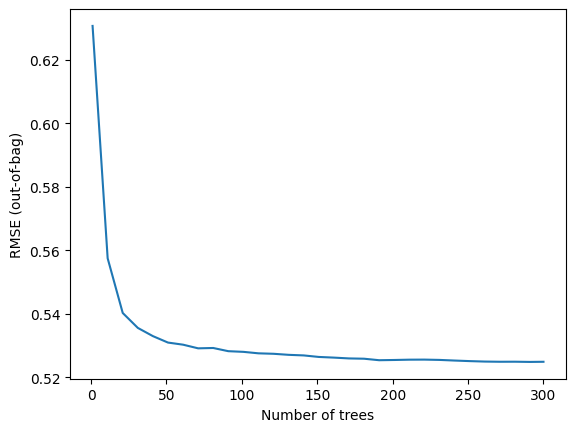

In [29]:
logs = model_4_content.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

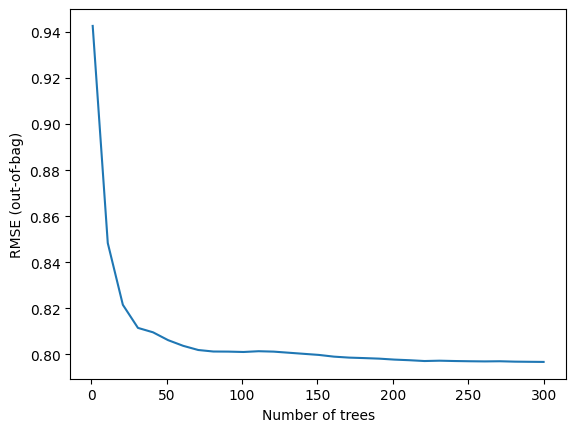

In [30]:
logs = model_4_wording.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [31]:
inspector_waala_content=model_4_content.make_inspector()
inspector_waala_content.evaluation()

Evaluation(num_examples=5771, accuracy=None, loss=None, rmse=0.524881405985051, ndcg=None, aucs=None, auuc=None, qini=None)

In [32]:
inspector_waala_wording=model_4_wording.make_inspector()
inspector_waala_wording.evaluation()

Evaluation(num_examples=5771, accuracy=None, loss=None, rmse=0.7966614683890855, ndcg=None, aucs=None, auuc=None, qini=None)

In [33]:
content_valid = tfdf.keras.pd_dataframe_to_tf_dataset(test_set[feature_content], label="content", task = tfdf.keras.Task.REGRESSION)

# Create validation dataset for model_wording
wording_valid = tfdf.keras.pd_dataframe_to_tf_dataset(test_set[feature_wording], label="wording", task = tfdf.keras.Task.REGRESSION)

# Run evaluation for model_content
evaluation_content = model_4_content.evaluate(x=content_valid,return_dict=True)
for name, value in evaluation_content.items():
  print(f"{name}: {value:.4f}")
# Run evaluation for model_wording
evaluation_wording = model_4_wording.evaluate(x=wording_valid,return_dict=True)
for name, value in evaluation_wording.items():
  print(f"{name}: {value:.4f}")

2/2 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - mse: 0.2729
loss: 0.0000
mse: 0.2729
2/2 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - mse: 0.6378
loss: 0.0000
mse: 0.6378


In [34]:
test_prompt=pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv")
test_summary=pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")


In [35]:
test=test_summary.merge(test_prompt,on='prompt_id')

In [36]:
test.head()

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text
0,000000ffffff,abc123,Example text 1,Summarize...,Example Title 1,Heading\nText...
1,222222cccccc,abc123,Example text 3,Summarize...,Example Title 1,Heading\nText...
2,111111eeeeee,def789,Example text 2,Summarize...,Example Title 2,Heading\nText...
3,333333dddddd,def789,Example text 4,Summarize...,Example Title 2,Heading\nText...


In [37]:
processed_test=feature_creation(test)

In [38]:
processed_test.head()

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text,text_word_cnt,text_char_len,text_stopwords_cnt,text_punctuation_cnt,text_number_cnt
0,000000ffffff,abc123,Example text 1,Summarize...,Example Title 1,Heading\nText...,3,14,0,0,1
1,222222cccccc,abc123,Example text 3,Summarize...,Example Title 1,Heading\nText...,3,14,0,0,1
2,111111eeeeee,def789,Example text 2,Summarize...,Example Title 2,Heading\nText...,3,14,0,0,1
3,333333dddddd,def789,Example text 4,Summarize...,Example Title 2,Heading\nText...,3,14,0,0,1


In [39]:
test_transformed=tfdf.keras.pd_dataframe_to_tf_dataset(processed_test[feature_columns],task = tfdf.keras.Task.REGRESSION)

In [40]:
processed_test['content']=model_4_content.predict(test_transformed)
processed_test['wording']=model_4_wording.predict(test_transformed)

1/1 [==============================] - 0s 26ms/step


In [41]:
processed_test.head()

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text,text_word_cnt,text_char_len,text_stopwords_cnt,text_punctuation_cnt,text_number_cnt,content,wording
0,000000ffffff,abc123,Example text 1,Summarize...,Example Title 1,Heading\nText...,3,14,0,0,1,-1.355119,-1.409008
1,222222cccccc,abc123,Example text 3,Summarize...,Example Title 1,Heading\nText...,3,14,0,0,1,-1.355119,-1.409008
2,111111eeeeee,def789,Example text 2,Summarize...,Example Title 2,Heading\nText...,3,14,0,0,1,-1.355119,-1.409008
3,333333dddddd,def789,Example text 4,Summarize...,Example Title 2,Heading\nText...,3,14,0,0,1,-1.355119,-1.409008


In [42]:
processed_test[['student_id', 'content', 'wording']].to_csv('submission.csv',index=False)
display(pd.read_csv('submission.csv'))

,student_id,content,wording
0,000000ffffff,-1.35512,-1.409007
1,222222cccccc,-1.35512,-1.409007
2,111111eeeeee,-1.35512,-1.409007
3,333333dddddd,-1.35512,-1.409007
